# IMPORTS

In [1]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import pandas as pd


# Parallel Class

In [26]:
def predict(w, b, X):
    z = np.dot(X, w) + b
    return 1 if sigmoid(z) > 0.5 else 0

def sigmoid(z):
    # Use a numerically stable version
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))


class ParallelLogisticRegression:
    def __init__(self,spark=None):
        self.spark=spark
    
    #@staticmethod
    def readFile(self,filename):
        filename = 'botnet_tot_syn_l.csv'
        spark=self.spark
        rdd = spark.sparkContext.textFile(filename)
        header = rdd.first()
        data_rdd = rdd.filter(lambda line: line != header) \
                     .map(lambda line: [float(x) for x in line.split(',')])
        return data_rdd.map(lambda x: (np.array(x[:-1]), x[-1]))

    @staticmethod
    def normalize(rdd_Xy):
        count = rdd_Xy.count()
        sums = rdd_Xy.map(lambda x: x[0]).reduce(lambda a, b: a + b)
        means = sums / count
        var_sums = rdd_Xy.map(lambda x: (x[0] - means) ** 2).reduce(lambda a, b: a + b)
        stds = np.sqrt(var_sums / count)
        
        # Normalize features and cache the RDD for reuse in training
        normalized_rdd = rdd_Xy.map(lambda x: ((x[0] - means) / stds, x[1]))
        normalized_rdd.persist(StorageLevel.MEMORY_ONLY)  # Caching normalized data
        return normalized_rdd

    def train(rdd_Xy, iterations, learning_rate, lambda_reg):

        n = len(rdd_Xy.first()[0])  # number of features
        w = np.zeros(n)
        b = 0
        m = rdd_Xy.count()
        costs = []
        
        # Cache RDD to avoid recomputation across iterations
        rdd_Xy.persist(StorageLevel.MEMORY_ONLY)

        for i in range(iterations):
            # Parallel computation of gradients and cost
            gradients = rdd_Xy.map(lambda x: {
                'pred': sigmoid(np.dot(x[0], w) + b), 
                'x': x[0],  
                'y': x[1]   
            }).map(lambda d: {
                'dw': (d['pred'] - d['y']) * d['x'],
                'db': d['pred'] - d['y'],
                'cost': -d['y'] * np.log(d['pred']) - (1 - d['y']) * np.log(1 - d['pred'])
            }).reduce(lambda a, b: {
                'dw': a['dw'] + b['dw'],
                'db': a['db'] + b['db'],
                'cost': a['cost'] + b['cost']
            })

            # Update weights and bias
            dw = gradients['dw'] / m + (lambda_reg / m) * w
            db = gradients['db'] / m
            cost = gradients['cost'] / m + (lambda_reg / (2 * m)) * np.sum(w ** 2)

            # Gradient descent update step
            w -= learning_rate * dw
            b -= learning_rate * db
            costs.append(cost)
            
            if i % 2 == 0:
                print(f"Iteration {i}, Cost: {cost}")
        
        # Unpersist RDD after training
        rdd_Xy.unpersist()
        
        return w, b, costs

    @staticmethod
    def accuracy(w, b, rdd_Xy):

        correct_predictions = rdd_Xy.map(lambda x: (predict(w, b, x[0]) == x[1])).reduce(lambda a, b: a + b)
        return correct_predictions / rdd_Xy.count()


    #@staticmethod
    def evaluate_performance(self,num_cores_range,iterations=10 ,normalized_rdd=None ):
        performance_results = []
        self.spark = None 

        # Configure Spark for different core counts
        for cores in num_cores_range:
            filename = 'botnet_tot_syn_l.csv'
            
            if hasattr(self, 'spark') and self.spark is not None:
                self.spark.stop()

            self.spark = SparkSession.builder \
                .appName(f"LogisticRegression_{cores}") \
                .config("spark.executor.cores", cores) \
                .config("spark.default.parallelism", cores) \
                .config("spark.sql.shuffle.partitions",cores) \
                .getOrCreate()

            spark=self.spark
            
            data_rdd = self.readFile(filename)
            normalized_rdd = ParallelLogisticRegression.normalize(data_rdd)

            start_time = time.time()

            # Train model
            w, b, costs = ParallelLogisticRegression.train(
                normalized_rdd, 
                iterations=iterations,
                learning_rate=0.1,
                lambda_reg=0.1
            )
            end_time = time.time()
            execution_time = end_time - start_time
            print(f'Execution time for {cores} cores:',execution_time)
            
            accuracy = ParallelLogisticRegression.accuracy(w, b, normalized_rdd)
            performance_results.append({
                'cores': cores,
                'time': execution_time,
                'accuracy': accuracy
            })
 
            self.spark.stop()
            self.spark = None 
        return performance_results


# Evaluation functions

In [3]:


def plot_performance_curves(results):
    cores = [r['cores'] for r in results]
    times = [r['time'] for r in results]
    speedups = [results[0]['time']/t for t in times]
    
    # Plot performance curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cores, times, 'bo-')
    plt.xlabel('Number of Cores')
    plt.ylabel('Execution Time (s)')
    plt.title('Performance Curve')
    
    # Plot speedup curve
    plt.subplot(1, 2, 2)
    plt.plot(cores, speedups, 'ro-')
    plt.xlabel('Number of Cores')
    plt.ylabel('Speedup')
    plt.title('Speedup Curve')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate ROC and Precision-Recall Curves
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

def plot_metrics(metrics):
    # Plot Confusion Matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Plot ROC Curve
    plt.subplot(2, 2, 2)
    plt.plot(metrics['fpr'], metrics['tpr'], label=f"AUC = {metrics['auc_roc']:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    
    # Plot Precision-Recall Curve
    plt.subplot(2, 2, 3)
    plt.plot(metrics['recall_curve'], metrics['precision_curve'])
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    # Show summary metrics 
    plt.subplot(2, 2, 4)
    plt.axis("off")
    summary_text = f"Precision: {metrics['precision']:.2f}\n" \
                   f"Recall: {metrics['recall']:.2f}\n" \
                   f"F1 Score: {metrics['f1']:.2f}\n" \
                   f"AUC-ROC: {metrics['auc_roc']:.2f}"
    plt.text(0.1, 0.5, summary_text, fontsize=12, ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


# Optimal core / partition count 

In [ ]:

    
# Test parallel version with different core counts
print("\nTesting optimal number of cores")

model = ParallelLogisticRegression()
results = model.evaluate_performance(range(1, 5),iterations=10, normalized_rdd=None)
plot_performance_curves(results)




Testing optimal number of cores


24/11/17 23:27:29 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_6_0


Iteration 0, Cost: 0.6931471805586802


Iteration 2, Cost: 0.6398165768860842


Iteration 4, Cost: 0.5954271122988762


Iteration 6, Cost: 0.5582330099571291


Iteration 8, Cost: 0.5268040024826823


Execution time for 1 cores: 89.72491455078125


24/11/17 23:29:24 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_6_0


Iteration 0, Cost: 0.6931471805586802


Iteration 2, Cost: 0.6398165768860842


Iteration 4, Cost: 0.5954271122988762


# Evaluation metrics 

Testing parallel version...


24/11/17 23:00:01 WARN BlockManager: Task 28 already completed, not releasing lock for rdd_6_0


Iteration 0, Cost: 0.6931471805586802


Iteration 2, Cost: 0.6398165768860842


Iteration 4, Cost: 0.5954271122988762


Iteration 6, Cost: 0.5582330099571291


Iteration 8, Cost: 0.5268040024826823


Parallel version execution time 72.21472549438477


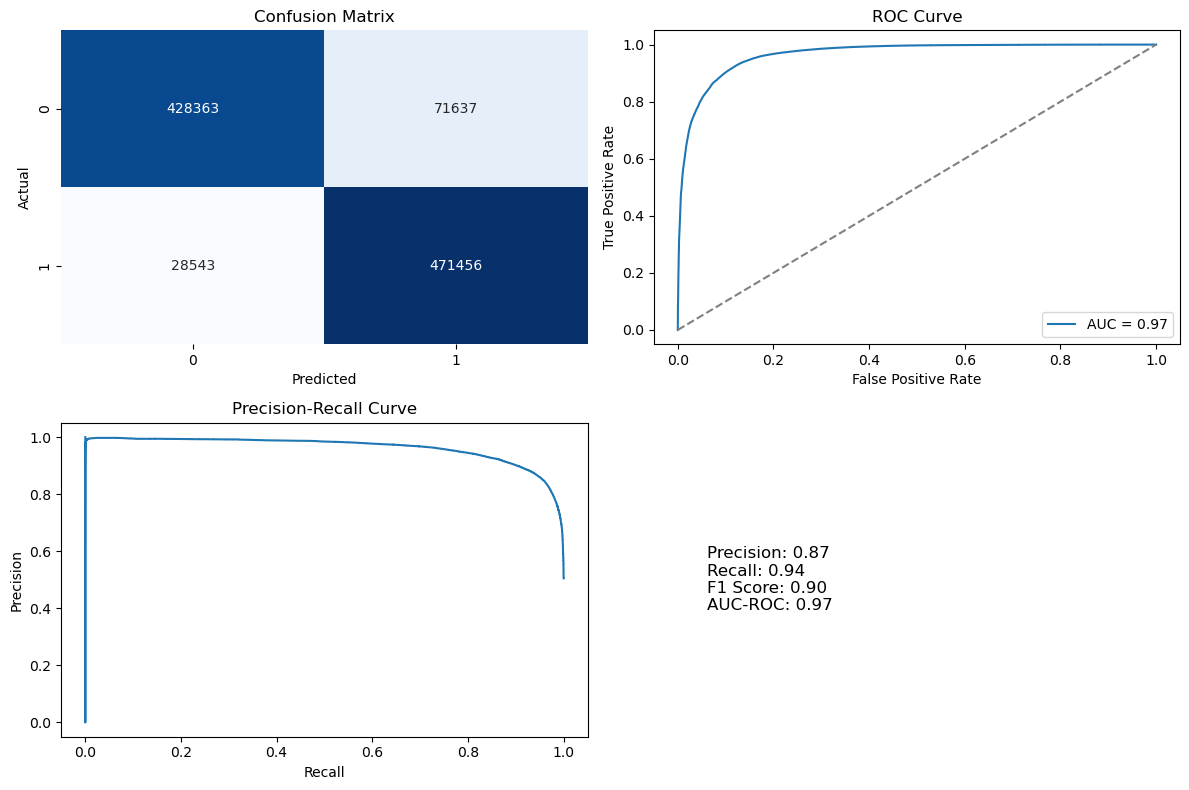

In [18]:

#data_rdd = ParallelLogisticRegression.readFile(filename)
#normalized_rdd = ParallelLogisticRegression.normalize(data_rdd)

filename = 'botnet_tot_syn_l.csv'
            


spark = SparkSession.builder \
    .appName(f"LogisticRegression_{2}") \
    .config("spark.executor.cores", 2) \
    .config("spark.default.parallelism", 2) \
    .config("spark.sql.shuffle.partitions",2) \
    .getOrCreate()
model=ParallelLogisticRegression(spark)
data_rdd = model.readFile(filename)
normalized_rdd = ParallelLogisticRegression.normalize(data_rdd)

print("Testing parallel version...")
start_time=time.time()
w, b, _ = ParallelLogisticRegression.train(normalized_rdd, iterations=10, learning_rate=0.1, lambda_reg=0.1)
end_time=time.time()
execution_time = end_time - start_time
print(f"Parallel version execution time {execution_time}")

# Obtain predictions and probabilities in parallel
y_true = normalized_rdd.map(lambda x: x[1]).collect()
y_pred_parallel = normalized_rdd.map(lambda x: predict(w, b, x[0])).collect()
y_prob_parallel = normalized_rdd.map(lambda x: sigmoid(np.dot(x[0], w) + b)).collect()

# Calculate and plot metrics for parallel version
metrics_parallel = calculate_metrics(np.array(y_true), np.array(y_pred_parallel), np.array(y_prob_parallel))
plot_metrics(metrics_parallel)
spark.stop()

# RDD loader / SPARK UI :http://localhost:4040/jobs/

In [5]:


filename = "botnet_reduced_l.csv"
filename = 'botnet_tot_syn_l.csv'

spark = SparkSession.builder \
    .appName("LogisticRegression") \
    .getOrCreate()

spark.conf.set("spark.default.parallelism",2)
spark.conf.set("spark.sql.shuffle.partitions",2)

model = ParallelLogisticRegression()
data_rdd = model.readFile(filename)
normalized_rdd = model.ParallelLogisticRegression(data_rdd)


partition_sizes = data_rdd.glom().map(len).collect()

# Plotting partition sizes
plt.bar(range(len(partition_sizes)), partition_sizes)
plt.xlabel("Partition Index")
plt.ylabel("Number of Elements")
plt.title("Elements per Partition")
plt.show()


24/11/14 23:10:03 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/11/14 23:10:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/11/14 23:10:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/14 23:10:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


TypeError: readFile() missing 1 required positional argument: 'filename'

# Optional spark configuration information

In [15]:
# Print all Spark configurations
for item in spark.sparkContext.getConf().getAll():
    print(f"{item[0]} = {item[1]}")


spark.driver.extraJavaOptions = -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED
spark.app.startTime = 1731271305797
spark.executor.id = driver
spark.driver.host = 10.0.2.15
spark.app.submitTime = 1731265868748
spark.app.id = local-1731271305852
spark.driver.port = 39511
spark.rdd.compress = True
spark.executor.extraJavaO

In [16]:

# Retrieve and display Spark configuration settings in a DataFrame
config = spark.sparkContext.getConf().getAll()
config_df = pd.DataFrame(config, columns=['Parameter', 'Value'])
print(config_df)  


                             Parameter  \
0        spark.driver.extraJavaOptions   
1                  spark.app.startTime   
2                    spark.executor.id   
3                    spark.driver.host   
4                 spark.app.submitTime   
5                         spark.app.id   
6                    spark.driver.port   
7                   spark.rdd.compress   
8      spark.executor.extraJavaOptions   
9                       spark.app.name   
10  spark.serializer.objectStreamReset   
11                        spark.master   
12                spark.submit.pyFiles   
13             spark.submit.deployMode   
14             spark.sql.warehouse.dir   
15        spark.ui.showConsoleProgress   

                                                Value  
0   -XX:+IgnoreUnrecognizedVMOptions --add-opens=j...  
1                                       1731271305797  
2                                              driver  
3                                           10.0.2.15  
4    

In [35]:
spark.stop()